Link to the **ARID_Dataset** : https://xuyu0010.github.io/arid.html

Importing Required Libraries.

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping



*   **Defining Image Size**
*   **Reading Dataset**


In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 32, 32
SEQUENCE_LENGTH = 5
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/ARID_Project_Modified_Data"
CLASSES_LIST = os.listdir("/content/drive/MyDrive/Colab Notebooks/ARID_Project_Modified_Data")
print(CLASSES_LIST)

['Jump', 'Pick', 'Push', 'Run', 'Pour', 'Drink', 'Sit', 'Stand', 'Turn', 'Walk', 'Wave']




*   **The Frames are Extracted from the enhanced Dataset.**
*   **The Extracted Frames are converted into array and normalized.**



In [ ]:
def frame_extractor(video_path):
  frames = []
  video_capture = cv2.VideoCapture(video_path)
  total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames = max(int(total_frames/SEQUENCE_LENGTH),1)

  for frame_counter in range(SEQUENCE_LENGTH):
    video_capture.set(cv2.CAP_PROP_FRAME_COUNT, frame_counter*skip_frames)
    success, frame = video_capture.read()
    if not success:
      break

    resized_image = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_image = resized_image/255
    frames.append(normalized_image)

  return frames

# Here, Dataset is created by:

*   **Storing the Frames in features.**
*   **Storing Class_index in labels.**

**These are the outputs here.**









In [ ]:
def create_dataset():

  features = []
  labels = []
  video_files_paths = []

  for class_index, class_name in enumerate(CLASSES_LIST):
    print(f'Extracting Data of class: {class_name}')
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
    for file_name in files_list:
      video_file_paths = os.path.join(DATASET_DIR, class_name, file_name)
      frames = frame_extractor(video_file_paths)

      features.append(frames)
      labels.append(class_index)
      video_files_paths.append(video_file_paths)

  features = np.asarray(features)
  labels = np.asarray(labels)

  return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of class: Jump
Extracting Data of class: Pick
Extracting Data of class: Push
Extracting Data of class: Run
Extracting Data of class: Pour
Extracting Data of class: Drink
Extracting Data of class: Sit
Extracting Data of class: Stand
Extracting Data of class: Turn
Extracting Data of class: Walk
Extracting Data of class: Wave


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

**Splitting the dataset.**

In [ ]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            random_state = 5)

In [ ]:
features_train.shape

(4947, 5, 32, 32, 3)

# Model Created: ***CNN***

In [ ]:
from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import TimeDistributed, Dropout
from tensorflow.keras import regularizers
from keras.layers import LSTM



def create_Convolutional_model():

  model = Sequential()

  model.add(TimeDistributed(Conv2D(8, kernel_size = (3,3), padding = 'same', strides =(1,1), activation = 'tanh',kernel_regularizer=regularizers.l2(0.01)),
                                   input_shape = (SEQUENCE_LENGTH, IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(TimeDistributed(MaxPooling2D(pool_size = (2,2))))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(TimeDistributed(Conv2D(16, kernel_size = (3,3), padding = 'same', strides =(1,1), activation = 'tanh', kernel_regularizer=regularizers.l2(0.01))))
  model.add(TimeDistributed(MaxPooling2D(pool_size = (2,2))))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(TimeDistributed(Conv2D(32, kernel_size = (3,3), padding = 'same', strides =(1,1), activation = 'tanh', kernel_regularizer=regularizers.l2(0.01))))
  model.add(TimeDistributed(MaxPooling2D(pool_size = (2,2))))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(TimeDistributed(Conv2D(64, kernel_size = (3,3), padding = 'same', strides =(1,1), activation = 'tanh', kernel_regularizer=regularizers.l2(0.01))))
  model.add(TimeDistributed(MaxPooling2D(pool_size = (2,2))))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

  model.summary()

  return model

In [ ]:
Convolutional_model = create_Convolutional_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 5, 32, 32, 8)     224       
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 5, 16, 16, 8)     0         
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 5, 16, 16, 8)     0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 5, 16, 16, 16)    1168      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 5, 8, 8, 16)     

We have added a function here to get Top 5 accuracy, usually we get Top 1 accuracy.

*   ***Top 1 accuracy*** : Top-1 accuracy is the conventional accuracy: the model answer (the one with highest probability) must be exactly the expected answer.
*   ***Top 5 accuracy*** : Top-5 accuracy means that any of your model 5 highest probability answers must match the expected answer.



In [ ]:
from keras.metrics import top_k_categorical_accuracy

def top_5_accuracy(y_true, y_pred):
  return top_k_categorical_accuracy(y_true, y_pred, k=5)




*   **Early Dtopping callback is used to prevent overfitting.**
*   **validation split is also given to plot graph and check how model is performing.**

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', verbose = 1, patience = 10, mode = 'auto',
                                        restore_best_weights= False)

Convolutional_model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy', metrics = ['accuracy', top_5_accuracy])

Convolutional_model_history = Convolutional_model.fit(features_train, labels_train, validation_split = 0.2,
                                                     batch_size = 16, epochs = 50, shuffle = True,callbacks = [early_stopping_callback],)

Epoch 1/50
248/248 [==============================] - 7s 19ms/step - loss: 2.6399 - accuracy: 0.1178 - top_5_accuracy: 0.5444 - val_loss: 2.4157 - val_accuracy: 0.1333 - val_top_5_accuracy: 0.5949
Epoch 2/50
248/248 [==============================] - 4s 16ms/step - loss: 2.3548 - accuracy: 0.1428 - top_5_accuracy: 0.6138 - val_loss: 2.3154 - val_accuracy: 0.1697 - val_top_5_accuracy: 0.6626
Epoch 3/50
248/248 [==============================] - 4s 16ms/step - loss: 2.2717 - accuracy: 0.1802 - top_5_accuracy: 0.6823 - val_loss: 2.2206 - val_accuracy: 0.2495 - val_top_5_accuracy: 0.6828
Epoch 4/50
248/248 [==============================] - 4s 16ms/step - loss: 2.1790 - accuracy: 0.2282 - top_5_accuracy: 0.7387 - val_loss: 2.1267 - val_accuracy: 0.2636 - val_top_5_accuracy: 0.7636
Epoch 5/50
248/248 [==============================] - 4s 16ms/step - loss: 2.0825 - accuracy: 0.2712 - top_5_accuracy: 0.7943 - val_loss: 2.0650 - val_accuracy: 0.3010 - val_top_5_accuracy: 0.8020
Epoch 6/50
248/



*   ***Top 1 accuracy*** : 73.32%
*   ***Top 5 accuracy*** : 97.41%

According to the website, our accuracy lies in **top - 3.**



In [ ]:
Convolutional_model.evaluate(features_test, labels_test)

39/39 [==============================] - 0s 6ms/step - loss: 1.1773 - accuracy: 0.7332 - top_5_accuracy: 0.9741


[1.1773139238357544, 0.7332255244255066, 0.9741309881210327]

***Graph is plotted between accuracy and validation accuracy.***

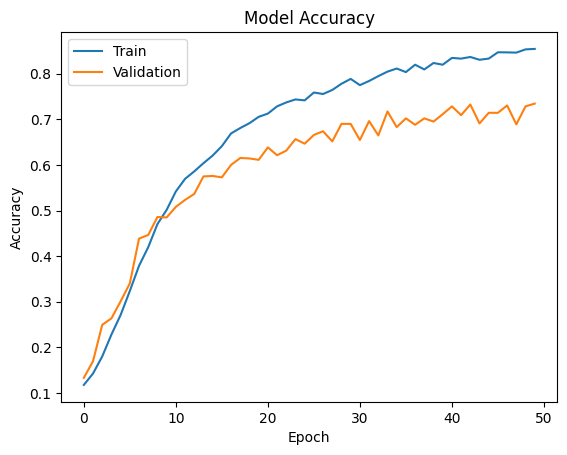

In [ ]:
plt.plot(Convolutional_model_history.history['accuracy'])
plt.plot(Convolutional_model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

***Graph is plotted between loss and validation loss.***

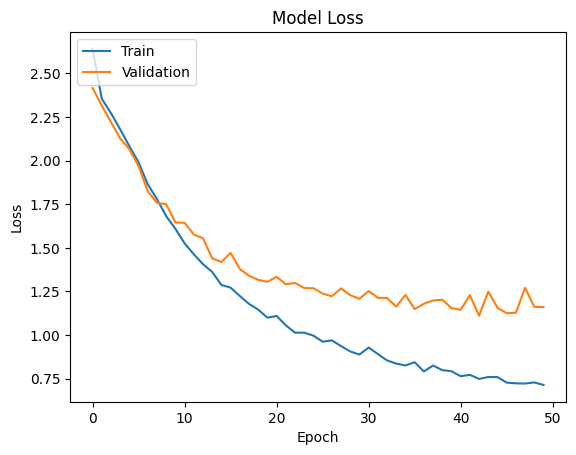

In [ ]:
plt.plot(Convolutional_model_history.history['loss'])
plt.plot(Convolutional_model_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

***Graph is plotted between Top 5 accuracy and validation Top 5 accuracy.***

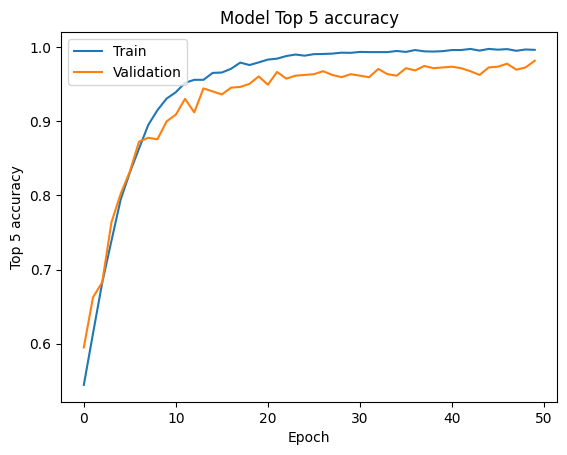

In [ ]:
plt.plot(Convolutional_model_history.history['top_5_accuracy'])
plt.plot(Convolutional_model_history.history['val_top_5_accuracy'])
plt.title('Model Top 5 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Top 5 accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()